In [67]:
#%%
import re
import os
# add the parent directory to the path
import sys
sys.path.append('../../')
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal
from utils import *
import seaborn as sns

ab_folder_path = '../experiment_data/tk_tet_03122024/AB'
od_folder_path = '../experiment_data/tk_tet_03122024/OD'

exp_layout = {0:(0,['B','C','D']),
              10:(0,['E','F','G']),
              50:(1,['B','C','D']),
              100:(1,['E','F','G']),
              'control':(2,['B','C','D']),
              400:(2,['E','F','G'])}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


# pickle_file = '../calibration_code/calibration_02152024.pkl'
pickle_file = '../calibration_code/calibration_02152024.pkl'
res = pickle.load(open(pickle_file,'rb'))

def ab_to_cfu(ab):
    return 10**(res.slope*np.log10(ab) + res.intercept)

rfu30_to_dilution = cal.run()

def od_to_cfu(OD):
    slope = 0.94
    intercept = 5.75
    return 10**(np.log10(OD) * slope + intercept)

In [68]:
cell_count_mean_od = {}
cell_count_std_od = {}

od_raw = {}
od_raw_std = {}

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(od_folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,8))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key] - 0.05
            # col_indx += 1
            row_indx += 1

    # cell_count_data = rfu_to_dilution(data_t,background_subtracted=False)
    data_t[data_t <= 0] = 1
    cell_count = od_to_cfu(data_t)
    # cell_count_log = rfu_to_dilution.predict(rfu_t.reshape(-1,1))

    cell_count_mean_od[exp_key] = np.mean(cell_count,axis=0)
    cell_count_std_od[exp_key] = np.std(cell_count,axis=0)

    od_raw[exp_key] = data_t
    od_raw_std[exp_key] = np.std(data_t,axis=0)

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time_od = np.array(time)

In [111]:
cell_count_mean_ab = {}
cell_count_std_ab = {}

ab_raw = {}
ab_raw_std = {}

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(ab_folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,7))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key] - 200
            # col_indx += 1
            row_indx += 1

    # cell_count_data = rfu_to_dilution(data_t,background_subtracted=False)
    # data_t[data_t <= 0] = 1
    # cell_count = rfu30_to_dilution(data_t,background_subtracted=True)
    cell_count = ab_to_cfu(data_t)
    # cell_count_log = rfu_to_dilution.predict(rfu_t.reshape(-1,1))

    cell_count_mean_ab[exp_key] = np.mean(cell_count,axis=0)
    cell_count_std_ab[exp_key] = np.std(cell_count,axis=0)

    ab_raw[exp_key] = data_t
    ab_raw_std[exp_key] = np.std(data_t,axis=0)

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time_ab = np.array(time)

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_94324/1624813733.py:48: RuntimeWarning: invalid value encountered in log10
  return 10**(res.slope*np.log10(ab) + res.intercept)


In [70]:
time_ab

array([  0.        ,  39.18333333,  83.08333333, 122.71666667,
       162.13333333, 208.2       , 267.18333333])

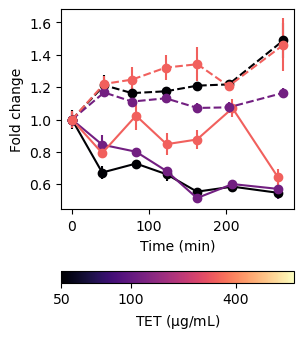

In [139]:
fig,ax = plt.subplots(figsize=(3,4),sharey=True)

cmap = sns.color_palette("magma", as_cmap=True)

keys = [50,100,400]

# for j,exp_key in enumerate(exp_layout.keys()):
for j,exp_key in enumerate(keys):
    if exp_key != 'control':
        y = cell_count_mean_ab[exp_key]
        err = cell_count_std_ab[exp_key]

        # y = y/ctrl
        err = err/y[0]
        y = y/y[0]

        ax.errorbar(time_ab,y,yerr=err,fmt='-o',color=cmap(j/3))
    
for j,exp_key in enumerate(keys):
    if exp_key != 'control':
        y = cell_count_mean_od[exp_key]
        err = cell_count_std_od[exp_key]

        err = err/y[0]
        y = y/y[0]

        ax.errorbar(time_od[0:-1],y[0:-1],yerr=err[0:-1],fmt='--o',color=cmap(j/3))
    
# ax.set_yscale('log')
        
# for ax in ax_list:
#     ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax.set_xlabel('Time (min)')
ax.set_ylabel('Fold change')

cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),ax=ax,
            label='TET ($\mathrm{\mu g/mL}$)',orientation='horizontal',pad=0.2)
            # boundari)

cbar.set_ticks([0,0.3,0.75])
cbar.set_ticklabels([50,100,400])


Text(0.5, 1.0, 'OD')

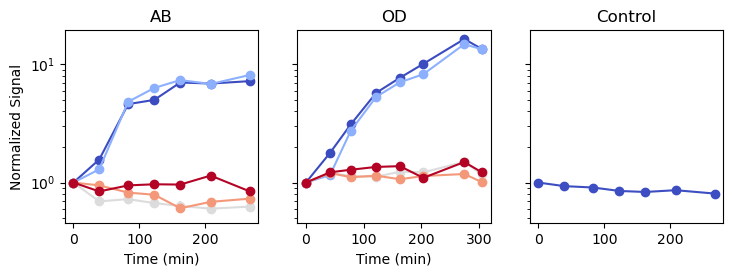

In [100]:
fig,ax_list = plt.subplots(ncols=3,figsize=(8.5,2.5),sharey=True)

cmap = sns.color_palette("coolwarm", as_cmap=True)

ax = ax_list[2]

key = 'control'
y = ab_raw[key][0]
err = ab_raw_std[key][0]

err = err/y[0]
ctrl = y/y[0]

ax.errorbar(time_ab,ctrl,yerr=err,fmt='-o',color=cmap(1))

ax.set_title('Control')

ax = ax_list[0]


for j,exp_key in enumerate(exp_layout.keys()):
    if exp_key != 'control':
        y = ab_raw[exp_key][0]
        err = ab_raw_std[exp_key][0]

        err = err/y[0]
        y = y/y[0]

        y = y/ctrl

        ax.errorbar(time_ab,y,yerr=err,fmt='-o',color=cmap(j/4))
    
ax.set_yscale('log')

ax = ax_list[1]

for j,exp_key in enumerate(exp_layout.keys()):
    if exp_key != 'control':
        y = od_raw[exp_key][0]
        err = od_raw_std[exp_key][0]

        err = err/y[0]
        y = y/y[0]

        ax.errorbar(time_od,y,yerr=err,fmt='-o',color=cmap(j/4))
    
ax.set_yscale('log')

ax_list[0].set_ylabel('Normalized Signal')

ax_list[0].set_xlabel('Time (min)')
ax_list[1].set_xlabel('Time (min)')

ax_list[0].set_title('AB')
ax_list[1].set_title('OD')



In [140]:
cell_count_mean_ab

{0: array([ 26482.76438443,  38397.64243494, 113306.72285012, 131692.41740086,
        152355.78125104, 156914.97437858, 173799.29515707]),
 10: array([ 25982.86962661,  39175.67033297,  96999.66993856, 140107.42414198,
        153376.80582482, 167044.37265446, 154485.52754324]),
 50: array([129826.70351386,  87290.57455079,  94492.91583082,  85890.48502997,
         71945.88887911,  75966.80366141,  71030.73898523]),
 100: array([113501.40590578,  95865.07933859,  90900.24427524,  77331.94209461,
         58403.9817781 ,  68217.09355632,  64843.5115482 ]),
 'control': array([1049.47429769,  606.15522968,  458.87657315,  267.69663968,
                  nan,  329.61377961,           nan]),
 400: array([ 93589.5271208 ,  74173.77688173,  95824.14893133,  79334.64717612,
         82031.11933539, 100167.97385372,  60176.78577261])}